In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from positioning.readwav import readwav
from positioning.create_db import create_3d_spectrum_db
from positioning.estimate import estimate_direction_3d, estimate_height, calc_position

In [3]:
# sns.set(style="whitegrid")
plt.style.use(["science", "notebook", "./slide.mplstyle"])

In [4]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'pgf', 'retro', 'russian-font', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'turkish-font', 'vibrant']


In [5]:
reference = pd.read_csv("../data/reference_3d_phone/reference_3d_position.csv")

In [6]:
cur_ref = reference.query("elevation < 40")

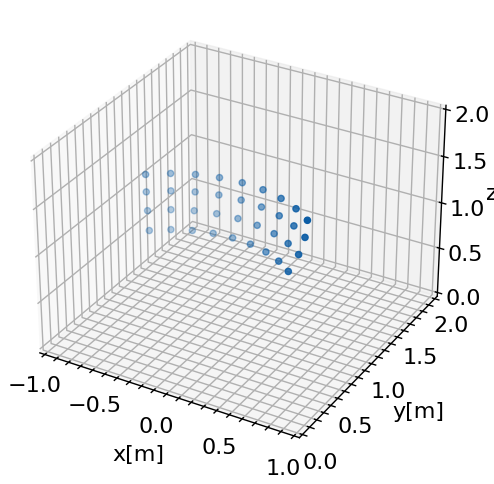

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(cur_ref["x"], cur_ref["y"], cur_ref["mcs_z"])
ax.set_xlim(-1, 1)
ax.set_ylim(0, 2)
ax.set_zlim(0, 2)
ax.set_xlabel("x[m]", labelpad=10)
ax.set_ylabel("y[m]", labelpad=10)
ax.set_zlabel("z[m]", labelpad=10)
fig.subplots_adjust(right=2)

In [8]:
db = create_3d_spectrum_db("../data/reference_3d_phone")

In [9]:
df_true = pd.read_csv("../data/pos_3d_first/true_positions.csv")

In [10]:
test_signal_d = [readwav(f"../data/pos_3d_first/test{i}d.wav")[:, 1] for i in range(9)]
test_signal_h = [readwav(f"../data/pos_3d_first/test{i}h.wav")[:, 1] for i in range(9)]

In [11]:
est_direction = np.array(
    [
        [estimate_direction_3d(db, s[i * 96000 : (i + 2) * 96000]) for i in range(100)]
        for s in test_signal_d
    ]
)
est_height = np.array(
    [
        [estimate_height(s[i * 7200 : i * 7200 + 48000]) for i in range(95)]
        for s in test_signal_h
    ]
)

In [12]:
est_height_hundred = np.concatenate(
    [est_height, np.tile(np.mean(est_height, axis=1), (5, 1)).T], axis=1
)
est_height_floor = 2.5 - est_height_hundred

In [13]:
est_position = np.array(
    [
        [calc_position(d[0], d[1], h) for d, h in zip(dd, hh)]
        for dd, hh in zip(est_direction, est_height_floor)
    ]
)

In [14]:
azimuth_error = np.array(
    [np.abs(d[:, 0] - df_true.iloc[i]["azimuth"]) for i, d in enumerate(est_direction)]
)
elevation_error = np.array(
    [
        np.abs(d[:, 1] - df_true.iloc[i]["elevation"])
        for i, d in enumerate(est_direction)
    ]
)
height_error = np.array(
    [np.abs(h - df_true.iloc[i]["mcs_z"]) for i, h in enumerate(est_height_floor)]
)
position_error = np.array(
    [
        [np.linalg.norm(pp - df_true.iloc[i].loc[["x", "y", "mcs_z"]]) for pp in p]
        for i, p in enumerate(est_position)
    ]
)

In [15]:
df_est = pd.DataFrame()
for i, d in enumerate(est_direction):
    df_est = pd.concat(
        [df_est, pd.DataFrame(d, columns=["azimuth", "elevation"]).assign(test=i)]
    ).reset_index(drop=True)
df_est = pd.concat(
    [df_est, pd.DataFrame(est_position.reshape(-1, 3), columns=["x", "y", "z"])], axis=1
)
df_est["azimuth_error"] = azimuth_error.reshape(-1)
df_est["elevation_error"] = elevation_error.reshape(-1)
df_est["height_error"] = height_error.reshape(-1)
df_est["position_error"] = position_error.reshape(-1)
df_est.head()

,azimuth,elevation,test,x,y,z,azimuth_error,elevation_error,height_error,position_error
0,-12,29,0,-0.168056,0.790644,1.108125,8.0,4.0,0.073125,0.238069
1,-12,29,0,-0.168056,0.790644,1.108125,8.0,4.0,0.073125,0.238069
2,-12,29,0,-0.168056,0.790644,1.108125,8.0,4.0,0.073125,0.238069
3,-12,29,0,-0.168056,0.790644,1.108125,8.0,4.0,0.073125,0.238069
4,-12,29,0,-0.168056,0.790644,1.108125,8.0,4.0,0.073125,0.238069


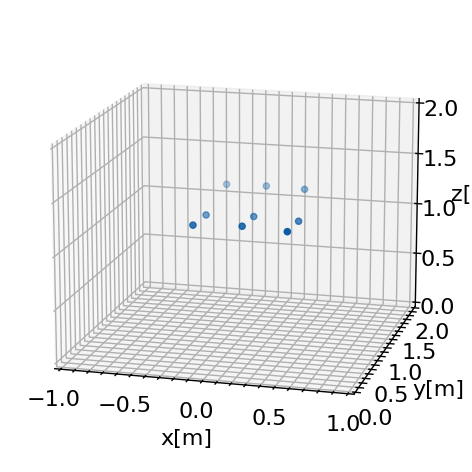

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(df_true["x"], df_true["y"], df_true["mcs_z"])
ax.set_xlim(-1, 1)
ax.set_ylim(0, 2)
ax.set_zlim(0, 2)
ax.set_xlabel("x[m]", labelpad=10)
ax.set_ylabel("y[m]", labelpad=10)
ax.set_zlabel("z[m]", labelpad=10)
ax.view_init(elev=15, azim=-75)

(0.0, 2.0)

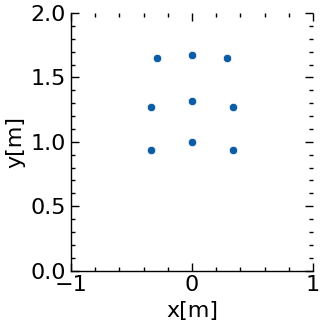

In [17]:
sns.relplot(df_true, x="x", y="y")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.xlim(-1, 1)
plt.ylim(0, 2)

Text(90.44444444444441, 0.5, 'CDF')

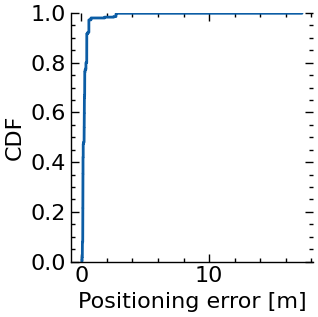

In [18]:
sns.displot(df_est, x="position_error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")

(0.0, 1.0)

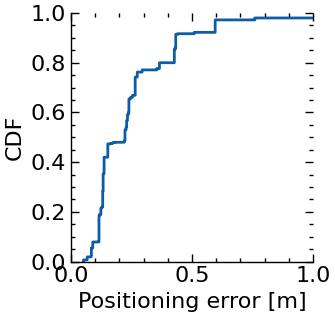

In [19]:
sns.displot(df_est, x="position_error", kind="ecdf")
plt.xlabel("Positioning error [m]")
plt.ylabel("CDF")
plt.xlim(0, 1)

Text(90.44444444444441, 0.5, 'CDF')

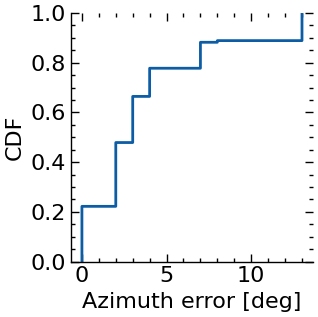

In [20]:
sns.displot(df_est, x="azimuth_error", kind="ecdf")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(116.14851388888887, 0.5, 'CDF')

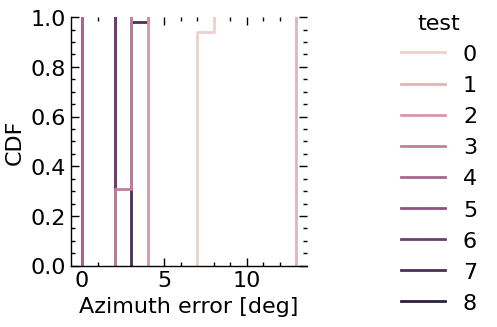

In [21]:
sns.displot(df_est, x="azimuth_error", kind="ecdf", hue="test")
plt.xlabel("Azimuth error [deg]")
plt.ylabel("CDF")

Text(90.44444444444441, 0.5, 'CDF')

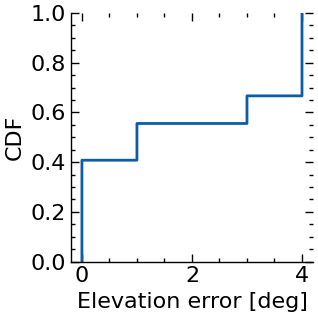

In [22]:
sns.displot(df_est, x="elevation_error", kind="ecdf")
plt.xlabel("Elevation error [deg]")
plt.ylabel("CDF")

Text(90.44444444444441, 0.5, 'CDF')

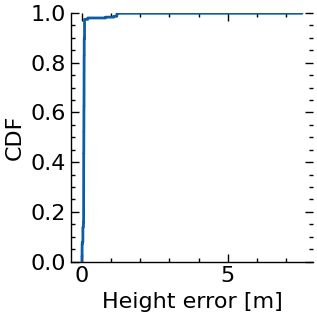

In [23]:
sns.displot(df_est, x="height_error", kind="ecdf")
plt.xlabel("Height error [m]")
plt.ylabel("CDF")

(0.0, 1.0)

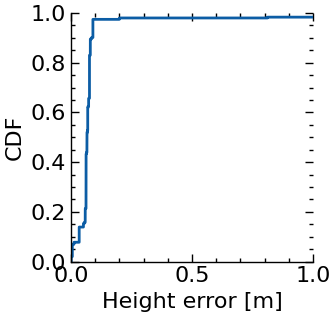

In [24]:
sns.displot(df_est, x="height_error", kind="ecdf")
plt.xlabel("Height error [m]")
plt.ylabel("CDF")
plt.xlim(0, 1)

In [25]:
pos_err_90p = np.percentile(df_est["position_error"], 90)
pos_err_50p = np.percentile(df_est["position_error"], 50)
azimuth_err_90p = np.percentile(df_est["azimuth_error"], 90)
azimuth_err_50p = np.percentile(df_est["azimuth_error"], 50)
elevation_err_90p = np.percentile(df_est["elevation_error"], 90)
elevation_err_50p = np.percentile(df_est["elevation_error"], 50)
height_err_90p = np.percentile(df_est["height_error"], 90)
height_err_50p = np.percentile(df_est["height_error"], 50)
print(
    f"pos_err_90p: {pos_err_90p:.3f}, pos_err_50p: {pos_err_50p:.3f},  height_err_90p: {height_err_90p:.3f}, height_err_50p: {height_err_50p:.3f}"
)
print(
    f"azimuth_err_90p: {azimuth_err_90p}, azimuth_err_50p: {azimuth_err_50p}, elevation_err_90p: {elevation_err_90p}, elevation_err_50p: {elevation_err_50p}"
)

pos_err_90p: 0.433, pos_err_50p: 0.223,  height_err_90p: 0.085, height_err_50p: 0.066
azimuth_err_90p: 13.0, azimuth_err_50p: 3.0, elevation_err_90p: 4.0, elevation_err_50p: 1.0
